In [1]:
its_jupyter_notebook = True

In [2]:
import pandas as pd
import os
import time
import numpy as np
import seaborn as sns
import pickle
import torch
from pathlib import Path
import argparse
import math
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc

sys.path.insert(0, '..')

from util.xai import gradcam, interpolate_expl_matrix, plot_matrix
from config import *
from models.nt_classifier import build as build_model 
from util.plot_utils import balance_df, obtain_plot, plot_logs, plot_roc_curves 
from util.plot_utils import collect_results_based_on_confidence_level_based_on_percentile as collect_results_based_on_confidence_level
if its_jupyter_notebook:
    sys.argv = [''] #Remove this if it's not a jupyter notebook!
    
external_dataset_dir = os.path.join(dataset_files_dir, 'external_dataset', '500_test_tables')

<class 'transformers.tokenization_dna.DNATokenizer'>


In [3]:
how = 'splash'
tool_name = 'priblast'

only_test = True
exclude_train_genes = False

MIN_N_READS_RICSEQ = 3

In [4]:
checkpoint_dir = os.path.join(ROOT_DIR, 'checkpoints', 'binary_cl2') 
#'less_samples_in_train',
#all_modelarch2_easypretrain3_paristfinetuning14_ricseq23_splash151
# all_modelarch2_easypretrain3_paristfinetuning14_ricseq23_splash151_trainall0198

In [16]:
res = pd.read_csv(os.path.join(checkpoint_dir, f'{how}_results500.csv'))

In [17]:
file_train = os.path.join(rna_rna_files_dir, f'{how}', 'gene_pairs_training.txt')
with open(file_train, "rb") as fp:   # Unpickling
    train_couples = pickle.load(fp)
    
file_test = os.path.join(rna_rna_files_dir, f'{how}', 'gene_pairs_test.txt')
with open(file_test, "rb") as fp:   # Unpickling
    test_couples = pickle.load(fp)
    
tr_genes=pd.Series(train_couples).str.extractall('(.*)_(.*)').reset_index()
training_genes = set(tr_genes[0]).union(tr_genes[1])

if only_test:
    res = res[res.couples.isin(test_couples)]
    if exclude_train_genes:
        res = res[~(res.gene1_original.isin(training_genes)) & (res.gene2_original.isin(training_genes))]

In [18]:
test500 = pd.read_csv(os.path.join(metadata_dir, f'{how}500.csv'))
df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt_{how}.csv'))

assert test500.shape[0] == df_nt[['couples', 'interacting', 'policy']].merge(test500, on = 'couples').shape[0]

if how == 'ricseq':
    test500 = df_nt[['couples', 'interacting', 'policy', 'where', 'where_x1', 'where_y1', 'simple_repeats', 'sine_alu', 'low_complex', 'n_reads']].merge(test500, on = 'couples')
    ids_to_keep = set(test500[test500.n_reads >= MIN_N_READS_RICSEQ].couples).union(test500[test500.interacting==False].couples)
    res = res[res.id_sample.isin(ids_to_keep)]
elif how == 'mario':
    test500 = df_nt[['couples', 'interacting', 'policy', 'where', 'where_x1', 'where_y1', 'simple_repeats', 'sine_alu', 'low_complex', 'n_reads']].merge(test500, on = 'couples')
elif how == 'splash':
    test500 = df_nt[['couples', 'interacting', 'policy', 'where', 'where_x1', 'where_y1', 'experiment']].merge(test500, on = 'couples')
else:
    raise NotImplementedError
    
id_cds_cds = set(test500[test500['where'] == 'CDS-CDS'].couples)

In [19]:
tool = pd.read_csv(os.path.join(external_dataset_dir, f'{tool_name}_{how}500.csv'), sep = ',').fillna(0)
assert (tool.minimum == True).all()

intarna = pd.read_csv(os.path.join(intarna_dir, f'{how}500_RANDOM', f'{how}.csv'), sep = ';')
intarna['key'] = intarna.id1 + '_' + intarna.id2

# keep only the lower E_norm for each group
intarna.sort_values('E_norm', ascending = False, inplace=True)
intarna.drop_duplicates(subset='key', keep='first', inplace=True)
intarna = intarna.reset_index(drop = True)
intarna['couples'] = intarna.id1.str.extractall('(.*)_(.*)').reset_index(drop = True)[0]
intarna['couples'] = intarna['couples'].astype(int)

intarna = intarna.dropna()

#intarna = intarna.dropna()
res = res.merge(intarna[['E','E_norm', 'couples']].rename({'couples':'id_sample'}, axis =1), on = 'id_sample')

res = res.merge(tool[['value', 'couples']].rename({'couples':'id_sample', 'value':tool_name}, axis =1), on = 'id_sample')

In [20]:
# Ranking the 'E_norm' column in ascending order
res['E_norm_conf'] = res['E_norm'].rank(ascending = False)

# Applying min-max scaling to get values between 0 and 1
res['E_norm_conf'] = (res['E_norm_conf'] - 1) / (len(res) - 1)

### L agreement score in questo caso di intarna non tiene conto dello sbilanciamento dei dati... dovrei prima trovare qual e l la soglia di INTARNA dove mettere lo 0.5 e poi fare la media con lo score del nostro modello
res['ensemble_score'] = (res['probability'] + res['E_norm_conf']) / 2
assert res.ensemble_score.max() <= 1
assert res.ensemble_score.min() >= 0

In [21]:
# exclude the common genes
# gene_count = pd.concat([res.gene1_original, res.gene2_original]).value_counts()
# rare_genes = list(gene_count[gene_count<20].index)
# res = res[res.gene1_original.isin(rare_genes) & res.gene2_original.isin(rare_genes)]

# PLOTS

## Metrics

In [22]:
print(res.prediction.value_counts())
print('\n')
print(res.ground_truth.value_counts())

1    276
0    249
Name: prediction, dtype: int64


1    273
0    252
Name: ground_truth, dtype: int64


In [23]:
n_conf = 10

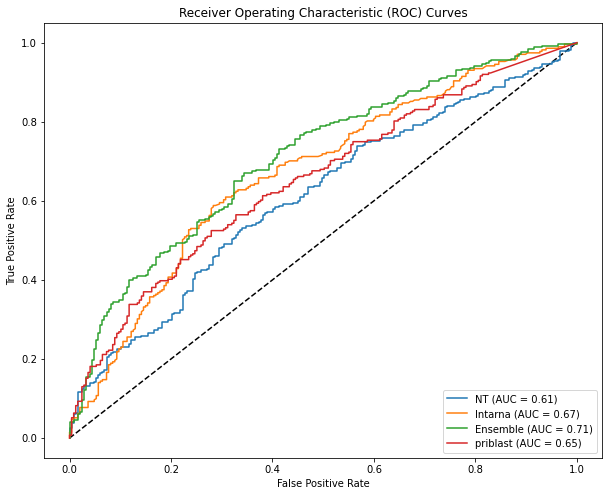

In [24]:
easypos_smartneg = res[res.policy.isin(['smartneg', 'easypos'])]

easypos_smartneg = balance_df(easypos_smartneg)

plot_roc_curves([{'prob': easypos_smartneg.probability, 'model_name': 'NT'},
                 {'prob': abs(easypos_smartneg.E_norm), 'model_name': 'Intarna'},
                 {'prob': abs(easypos_smartneg.ensemble_score), 'model_name': 'Ensemble'},
                 {'prob': abs(easypos_smartneg[tool_name]), 'model_name': tool_name}
                ], easypos_smartneg.ground_truth)

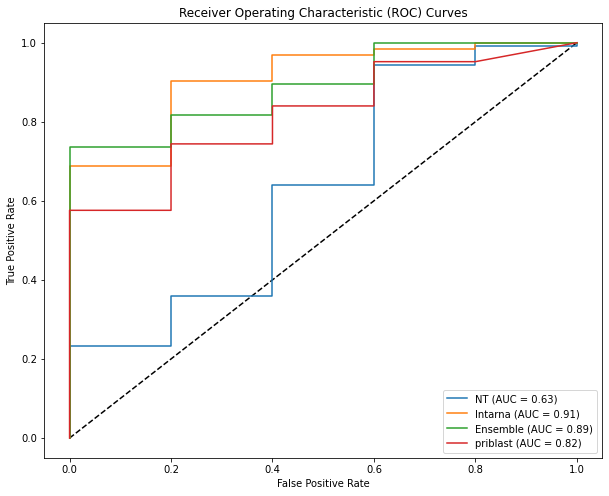

In [26]:
ephnen = res[(res.policy == 'easyneg')|(res.policy == 'easypos')|(res.policy == 'hardneg')]

ephnen_sampled = balance_df(ephnen)

plot_roc_curves([{'prob': ephnen_sampled.probability, 'model_name': 'NT'},
                 {'prob': abs(ephnen_sampled.E_norm), 'model_name': 'Intarna'},
                 {'prob': abs(ephnen_sampled.ensemble_score), 'model_name': 'Ensemble'},
                 {'prob': abs(ephnen_sampled[tool_name]), 'model_name': tool_name}
                ], ephnen_sampled.ground_truth)

# TODO: FAI QUESTI PLOT QUI SOTTO

Text(0.5, 0, 'Perc%')

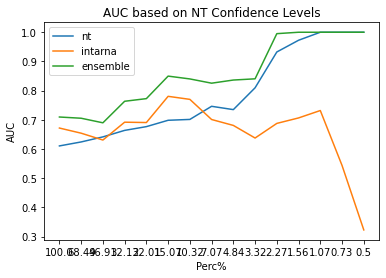

In [27]:
n_values = 15
MIN_PERC = 0.5

confidence_level, auc_nt, auc_intarna, auc_ens = collect_results_based_on_confidence_level(easypos_smartneg, how = 'nt', MIN_PERC = MIN_PERC, balance = False, n_values = n_values, space = 'log')
plt.plot(confidence_level, auc_nt, label = 'nt')
plt.plot(confidence_level, auc_intarna, label = 'intarna')
plt.plot(confidence_level, auc_ens, label = 'ensemble')
plt.title('AUC based on NT Confidence Levels')
plt.legend()

plt.ylabel('AUC')
plt.xlabel(f"Perc%")

Text(0.5, 0, 'Perc%')

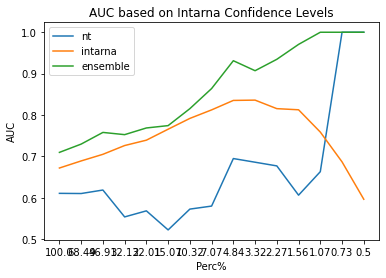

In [28]:
confidence_level, auc_nt, auc_intarna, auc_ens = collect_results_based_on_confidence_level(easypos_smartneg, how = 'intarna', MIN_PERC = MIN_PERC, balance = False, n_values = n_values, space = 'log')
plt.plot(confidence_level, auc_nt, label = 'nt')
plt.plot(confidence_level, auc_intarna, label = 'intarna')
plt.plot(confidence_level, auc_ens, label = 'ensemble')
plt.title('AUC based on Intarna Confidence Levels')
plt.legend()

plt.ylabel('AUC')
plt.xlabel(f"Perc%")

Text(0.5, 0, 'Perc%')

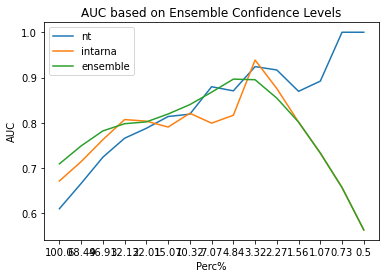

In [29]:
confidence_level, auc_nt, auc_intarna, auc_ens = collect_results_based_on_confidence_level(easypos_smartneg, how = 'ensemble', MIN_PERC = MIN_PERC, balance = False, n_values = n_values, space = 'log')
plt.plot(confidence_level, auc_nt, label = 'nt')
plt.plot(confidence_level, auc_intarna, label = 'intarna')
plt.plot(confidence_level, auc_ens, label = 'ensemble')
plt.title('AUC based on Ensemble Confidence Levels')
plt.legend()

plt.ylabel('AUC')
plt.xlabel(f"Perc%")